In [1]:
from data_cleaning import clean_tv_data as clean_new
from data_cleaning_replication import clean_tv_data as clean_replication
from binary_vectors import * 
from minhashing import *
from lsh import *
from true_pairs import *
from plotting import *
from msm import *
from distance_matrix import *
from f1_scores import *
from utilities import *
import itertools

input_file_path = "TVs-all-merged.json"
output_file_path = "data/TVs-all-merged-cleaned.json"
clean_new(input_file_path, output_file_path)

input_file_path = "TVs-all-merged.json"
output_file_path_replication = "data/TVs-all-merged-cleaned-replication.json"
clean_replication(input_file_path, output_file_path_replication)

with open(output_file_path, 'r') as file: 
    data_cleaned = json.load(file)

with open(output_file_path_replication, 'r') as file: 
    data_cleaned_replication = json.load(file)

all_products = [item for model_id, items in data_cleaned.items() for item in items]
all_pairs = list(itertools.combinations(range(len(all_products)), 2))
all_true_pairs = find_set_duplicates(all_products)

all_products_rep = [item for model_id, items in data_cleaned_replication.items() for item in items]
all_pairs_rep = list(itertools.combinations(range(len(all_products_rep)), 2))
all_true_pairs_rep = find_set_duplicates(all_products_rep)

train_ratio = 0.63
bootstraps = 5
num_products = len(all_products)
num_products_rep = len(all_products_rep)

PQ_train = {i: {} for i in range(bootstraps)}
PC_train= {i: {} for i in range(bootstraps)}
PQ_train_rep = {i: {} for i in range(bootstraps)}
PC_train_rep= {i: {} for i in range(bootstraps)}
F1_LSH = {i: {} for i in range(bootstraps)}
F1_LSH_rep = {i: {} for i in range(bootstraps)}



for i in range(bootstraps): 
    subset_size = int(num_products * train_ratio)
    train_subset = random.sample(all_products, subset_size)
    train_subset_rep = random.sample(all_products_rep, subset_size)

    train_num_products_subset = len(train_subset)
    train_subset_indices = list(range(train_num_products_subset))
    train_original_indices = [all_products.index(element) for element in train_subset]
    train_index_mapping = {subset_index: original_index for subset_index, original_index in zip(train_subset_indices, train_original_indices)}
    train_pairs, train_true_pairs, train_signature_matrix, n = get_signature_matrix(train_subset)
    rows, cols = train_signature_matrix.shape
    total_comparisons = (cols*(cols-1))/2

    train_num_products_subset_rep = len(train_subset_rep)
    train_subset_indices_rep = list(range(train_num_products_subset_rep))
    train_original_indices_rep = [all_products_rep.index(element) for element in train_subset_rep]
    train_index_mapping_rep = {subset_index: original_index for subset_index, original_index in zip(train_subset_indices_rep, train_original_indices_rep)}
    train_pairs_rep, train_true_pairs_rep, train_signature_matrix_rep, n = get_signature_matrix(train_subset_rep)
    rows_rep, cols_rep = train_signature_matrix_rep.shape
    total_comparisons_rep = (cols_rep*(cols_rep-1))/2
    
    for b in range(1,n+1): 
        if n % b != 0:
            continue

        r = n // b

        PQ_train[i][b] = {'PQ': 0, 'fraction_of_comparisons': 0}
        PC_train[i][b] = {'PC': 0, 'fraction_of_comparisons': 0}
        PQ_train_rep[i][b] = {'PQ': 0, 'fraction_of_comparisons': 0}
        PC_train_rep[i][b] = {'PC': 0, 'fraction_of_comparisons': 0}
        F1_LSH[i][b]={'F1':0, 'fraction_of_comparisons': 0}
        F1_LSH_rep[i][b]={'F1':0, 'fraction_of_comparisons': 0}


        # Original dataset
        candidate_pairs = lsh(train_signature_matrix, b, r)
        N_c = len(candidate_pairs)
        D_f = len(candidate_pairs.intersection(train_true_pairs))
        D_n = len(train_true_pairs)
        PQ = D_f / N_c if N_c != 0 else 0
        PC = D_f / D_n
        frac_comparisons = N_c / total_comparisons

        PQ_train[i][b]['PQ'] = PQ
        PQ_train[i][b]['fraction_of_comparisons'] = frac_comparisons
        PC_train[i][b]['PC'] = PC
        PC_train[i][b]['fraction_of_comparisons'] = frac_comparisons
        F1_LSH[i][b]['F1'] = (2 * PC * PQ)/(PC+PQ)
        F1_LSH[i][b]['fraction_of_comparisons'] = frac_comparisons
        


        # Original dataset
        candidate_pairs_rep = lsh(train_signature_matrix_rep, b, r)
        N_c = len(candidate_pairs_rep)
        D_f = len(candidate_pairs_rep.intersection(train_true_pairs_rep))
        D_n = len(train_true_pairs_rep)
        PQ_rep = D_f / N_c if N_c != 0 else 0
        PC_rep = D_f / D_n
        frac_comparisons_rep = N_c / total_comparisons_rep

        PQ_train_rep[i][b]['PQ'] = PQ_rep
        PQ_train_rep[i][b]['fraction_of_comparisons'] = frac_comparisons_rep
        PC_train_rep[i][b]['PC'] = PC_rep
        PC_train_rep[i][b]['fraction_of_comparisons'] = frac_comparisons_rep
        F1_LSH_rep[i][b]['F1'] = (2 * PC_rep * PQ_rep)/(PC_rep+PQ_rep)
        F1_LSH_rep[i][b]['fraction_of_comparisons'] = frac_comparisons_rep




Length binary matrix is: 2053
Length binary matrix is: 2120


KeyboardInterrupt: 

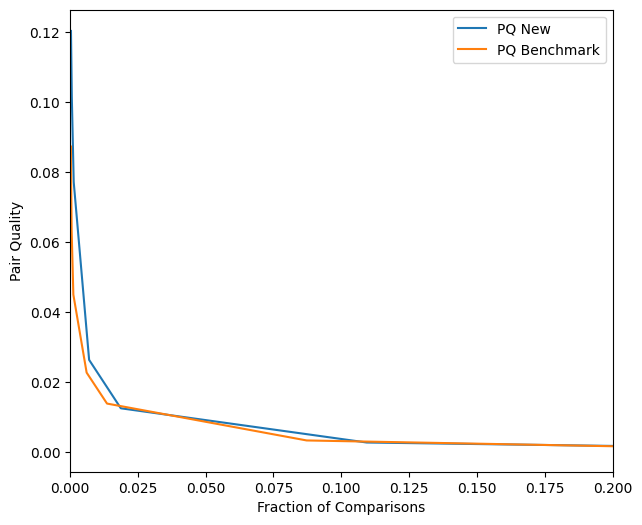

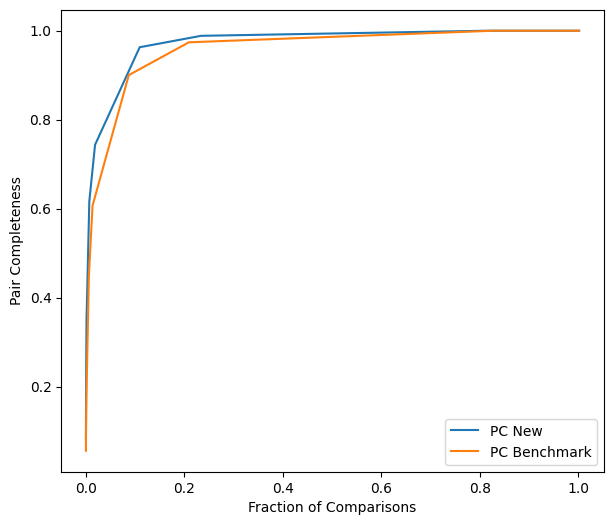

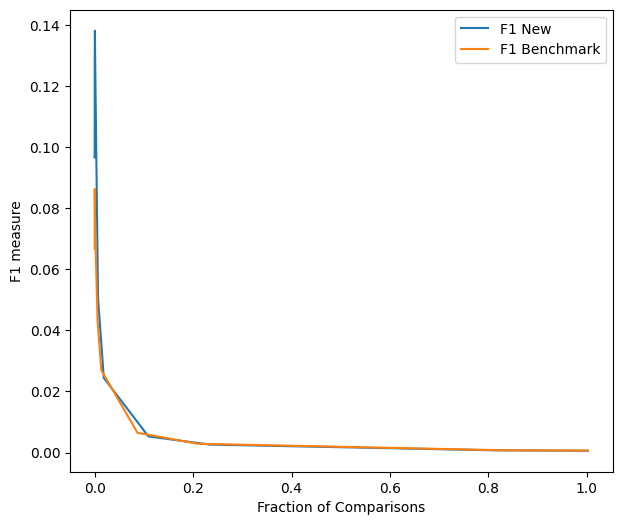

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_averages(PQ, key):
    averages = {}
    for b in PQ[0].keys():
        PQ_avg = np.mean([PQ[i][b][key] for i in range(bootstraps)])
        # PC_avg = np.mean([PQ_PC_train[i][b]['PC'] for i in range(bootstraps)])
        frac_comparisons_avg = np.mean([PQ[i][b]['fraction_of_comparisons'] for i in range(bootstraps)])
        averages[b] = {f'{key}_avg': PQ_avg, 'frac_comparisons_avg': frac_comparisons_avg}
    return averages


averages_PQ_train = calculate_averages(PQ_train, 'PQ')
averages_PQ_train_rep = calculate_averages(PQ_train_rep, 'PQ')

averages_PC_train = calculate_averages(PC_train, 'PC')
averages_PC_train_rep = calculate_averages(PC_train_rep, 'PC')

avgF1 = calculate_averages(F1_LSH, 'F1')
avgF1_rep = calculate_averages(F1_LSH_rep, 'F1')

# Extracting PQ and fraction of comparisons values for plotting
PQ_avg_train = [averages_PQ_train[b]['PQ_avg'] for b in averages_PQ_train]
frac_comparisons_avg_train = [averages_PQ_train[b]['frac_comparisons_avg'] for b in averages_PQ_train]

PQ_avg_train_rep = [averages_PQ_train_rep[b]['PQ_avg'] for b in averages_PQ_train_rep]
frac_comparisons_avg_train_rep = [averages_PQ_train_rep[b]['frac_comparisons_avg'] for b in averages_PQ_train_rep]



# Extracting PC and fraction of comparisons values for plotting
PC_avg_train = [averages_PC_train[b]['PC_avg'] for b in averages_PC_train]
frac_comparisons_avg_PC_train = [averages_PC_train[b]['frac_comparisons_avg'] for b in averages_PC_train]

PC_avg_train_rep = [averages_PC_train_rep[b]['PC_avg'] for b in averages_PC_train_rep]
frac_comparisons_avg_PC_train_rep = [averages_PC_train_rep[b]['frac_comparisons_avg'] for b in averages_PC_train_rep]

F1 = [avgF1[b]['F1_avg'] for b in avgF1]
frac_comparisons_F1 = [avgF1[b]['frac_comparisons_avg'] for b in avgF1]

F1_rep = [avgF1_rep[b]['F1_avg'] for b in avgF1_rep]
frac_comparisons_F1_rep = [avgF1_rep[b]['frac_comparisons_avg'] for b in avgF1_rep]


# PQ Plot
plt.figure(figsize=(7, 6))
plt.plot(frac_comparisons_avg_train, PQ_avg_train, label='PQ New')
plt.plot(frac_comparisons_avg_train_rep, PQ_avg_train_rep, label='PQ Benchmark')
plt.xlabel('Fraction of Comparisons')
plt.ylabel('Pair Quality')
plt.xlim(0, 0.2)  # Set x-axis limit
plt.legend()
plt.show()

# PC Plot
plt.figure(figsize=(7, 6))
plt.plot(frac_comparisons_avg_PC_train, PC_avg_train, label='PC New')
plt.plot(frac_comparisons_avg_PC_train_rep, PC_avg_train_rep, label='PC Benchmark')
plt.xlabel('Fraction of Comparisons')
plt.ylabel('Pair Completeness')
plt.legend()
plt.show()

# PC Plot
plt.figure(figsize=(7, 6))
plt.plot(frac_comparisons_F1, F1, label='F1 New')
plt.plot(frac_comparisons_F1_rep, F1_rep, label='F1 Benchmark')
plt.xlabel('Fraction of Comparisons')
plt.ylabel('F1 measure')
plt.legend()
plt.show()



{'F1': [0.09696940584912914, 0.09696940584912914, 0.09696940584912914, 0.09696940584912914, 0.09696940584912914, 0.09696940584912914, 0.09682594188197505, 0.09787961987725292, 0.104875338334733, 0.1289338244128878, 0.1388143933597631, 0.1263314921702478, 0.050421624470849385, 0.024457046926517397, 0.005278934760350075, 0.002603325216044556, 0.0007313624971394616, 0.0005947338947550043], 'frac_comparisons': [0.00022113694230353528, 0.00022113694230353528, 0.00022113694230353528, 0.00022113694230353528, 0.00022113694230353528, 0.00022113694230353528, 0.00022190212203468943, 0.00022381507136257466, 0.0002463878734316207, 0.00034815677767511616, 0.0006569067991957962, 0.0013593417923952612, 0.007040418706348887, 0.018731599818652404, 0.10937173005224265, 0.2340248645153639, 0.814368162401746, 1.0019569471624266]}
{'F1': [0.0671534729665097, 0.0671534729665097, 0.0671534729665097, 0.0671534729665097, 0.0671534729665097, 0.0671534729665097, 0.0671534729665097, 0.06824774848698001, 0.07194123

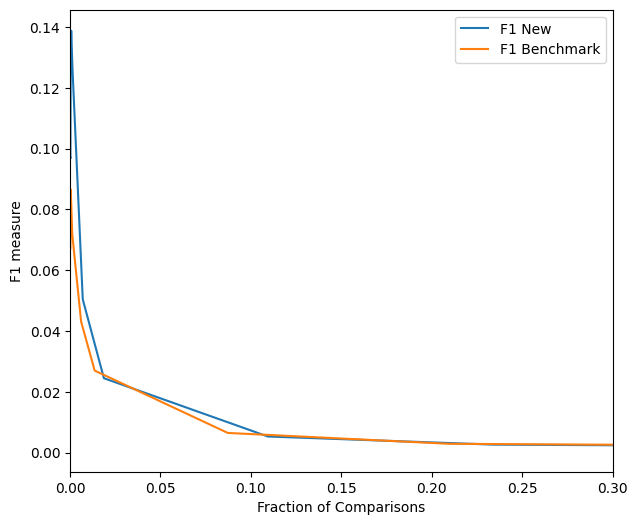

In [16]:
F1 = {"F1":[],"frac_comparisons":[]}
for pq, pc in zip(PQ_avg_train, PC_avg_train):
    F1["F1"].append((2 * pq * pc) / (pq + pc))

for fc in frac_comparisons_avg_train: 
    F1["frac_comparisons"].append(fc)

F1_rep = {"F1":[],"frac_comparisons":[]}
for pq, pc in zip(PQ_avg_train_rep, PC_avg_train_rep):
    F1_rep["F1"].append((2 * pq * pc) / (pq + pc))

for fc in frac_comparisons_avg_train_rep: 
    F1_rep["frac_comparisons"].append(fc)
print(F1)
print(F1_rep)

# PC Plot
plt.figure(figsize=(7, 6))
plt.plot(F1["frac_comparisons"], F1["F1"], label='F1 New')
plt.plot(F1_rep["frac_comparisons"], F1_rep["F1"], label='F1 Benchmark')
plt.xlabel('Fraction of Comparisons')
plt.xlim(0, 0.3)  # Set x-axis limit
plt.ylabel('F1 measure')
plt.legend()
plt.show()